Student: Aldous Birchall \
Project Group: Machine Learning for Spatial Data\
Supervisor: Dr James S. Martin\
18 June 2023

### Applications of machine learning for anomaly detection on maritime vessel automatic identification system (AIS) data.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd
from pointpats import QStatistic
from pointpats import PointPattern
from sklearn.cluster import DBSCAN
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
import warnings
warnings.simplefilter("ignore") # stops warnings on trajectories re euclidian dists
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Import data sample
# Source: AccessAIS tool at https://marinecadastre.gov/accessais/
# Sample created using AccessAIS drawing tool to create custom spatial boundaries and time range

ais_data = pd.read_csv("AIS_small_1D_sample.csv")

### Introduction

The Automatic identification system (AIS) came into widespread use after the Safety of Life at Sea (SOLAS) convention in 2002 stipulated that all maritime vessels over 300 GT (gross tonnage) were obliged to be equipped with an AIS transponder in order to transmit their position and velocity to other vessels in order to avoid collisions (Svanberg et al, 2019).

Ships equipped with AIS transponders periodically broadcast their spatial position to other vessels and authorities in their vicinity (Wolsing et al, 2022). AIS broadcasts contain information about the vessel from which it is emitted, including its geospatial location and velocity. The signal transmission frequency lies in a 2 to 12 second range for moving vessels with the frequency depending on the vessel's speed. Vessels at achor transmit every 3 minutes. 

Organisations such as coastguards and commercial data vendors systematically collect this data at varying geographic scales via terrestrial and satellite receivers. Consequently AIS data has become a rich source of information about maritime vessel movements. The data has many applications beyond collision avoidance such as surveillance for security and law enforcement, economic analysis, maritime planning activities, and mitigating environmental pollution (Svanberg et al, 2019).

Fig. 1 below shows AIS transmissions in and around Port Fourchon, USA, on 31st March 2020. The data was downloaded using the AccessAIS tool provided by a partnership of the Bureau of the Ocean Energy Management (BOEM), National Oceanic and Atmospheric Administration (NOAA) United States Coast Guard (USCG) at https://marinecadastre.gov/accessais/ . This is one of a number of methods available to download the data. Much larger files can be accessed at the site covering all U.S. coastal waters in 24 hour increments. The final report will probably use a larger data set because the sample in this notebook has been chosen for it's convenient size for basic exploratory data analysis, methodology testing and submission to Imperial College course tutors.

Figures 1 & 2 below plot all the spatial coordinates of the transmissions in the data set:

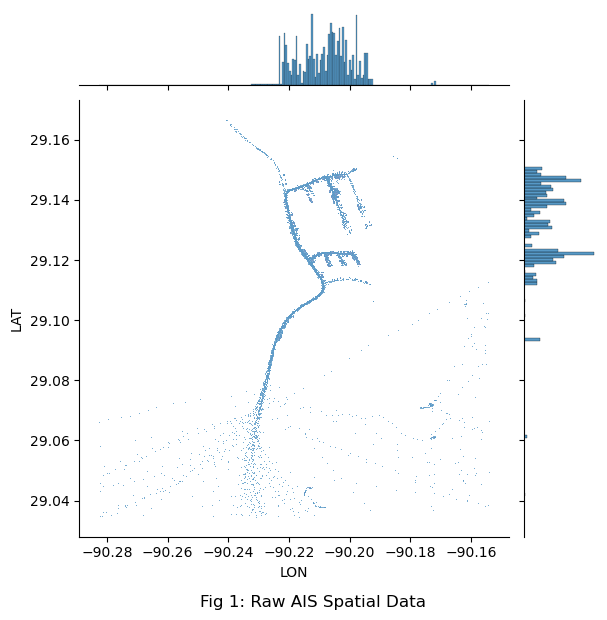

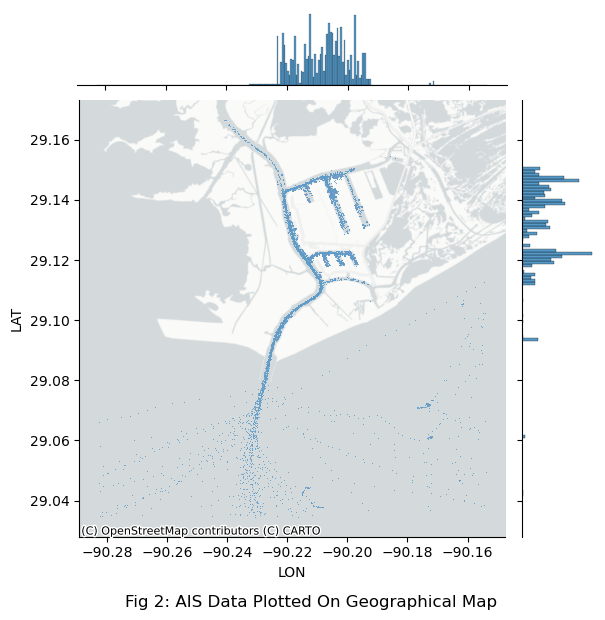

In [27]:
# Generate scatter plot of spatial components of data set

# Simple plot with histograms of Lattitde and Longitude values
sns.jointplot(data = ais_data, x="LON", y="LAT", s=0.5) 
plt.suptitle("Fig 1: Raw AIS Spatial Data",  y=0)

# Above plot combined with geographic map
joint_axes = sns.jointplot(data = ais_data, x="LON", y="LAT", s=0.5)

ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326", # define geographic projection convention for earth's surface
    source=ctx.providers.CartoDB.PositronNoLabels)
plt.suptitle("Fig 2: AIS Data Plotted On Geographical Map", y=0);

#### Potential methods given data structure

Figs. 1 & 2 above show that the spatial data from individual AIS transmissions form points on a quasi 2D plane (the earths surface) making them suitable for the application of spatial statistical methods. Because the spatial position (coordinate) is the variable of interest, point pattern analysis may be a suitable approach for some or all of the analysis.

Machine learning clustering techniques are often applied to 2D data to identify clusters of similar observations. Thus these methods may be effective in this domain and will be tested in this notebook.

Finally, physical sensor data on a 2D plane has proven amenable to Deep Learning methods (primarily on image data). These methods may be applicable to this data given the structural similarities. In this notebook we test a Variational Autoencoder on transformed AIS data.

#### Purpose of the analysis

The above methods have the potential to model salient features of the data generating process (vessel movements). With a suitable model we can detect anomalous behaviour as it will deviate from model predictions.

Wolsing et al (2022) review 44 papers on anomaly detection approaches for vessel trajectories derived from AIS spatiotemporal data. These papers used a wide range of statistical and machine learning methods.

One observation of the review is that not many papers featured Neural Networks, and those that did tended to use recurrent neural networks. Variational Autoencoders for anomaly detection were conspicuous by their absence.

In this notebook, the objective is to briefly review the practicality of a number of methods that could be used to develop a novel approach to anomaly detection on AIS data. This could be based on the use of well designed model covariates (features), or the novel application of a modelling approach such as VAEs.

One trade-off of interest is model bias (structure imposed by the designer given domain expertise) versus use of a sufficiently complex model that can automatically capture complex behaviour in the data generating process. This is an important trade-off because the behaviour under observation is complex human behaviour. Much of the literature on this topic comes from the marine engineering community so the application of domain expertise on vessel trajectories is widespread. From a data science or applied mathematics perspective, minimising reliance on domain knowledge and relying on data generated models is preferable. As such, elegant and parsimonious features and / or sophisticated modelling methods are the objective. 

#### Research question

The expected research question is "Are variational autoencoders an effective method for anomaly detection on AIS data?" If so how might they be applied and how do they compare to existing methods. The hypothesis is that the benefits of using deep learning (minimal feature engineering, capture of complex, hierarchical relationships) are very useful in this domain. Even if in the first instance the answer is that VAE's are not useful to this problem, then understanding why probably is.


### Basic exploratory data analsysis

For completeness, a sample of AIS transmissions is shown below:

In [4]:
ais_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85335 entries, 0 to 85334
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MMSI              85335 non-null  int64  
 1   BaseDateTime      85335 non-null  object 
 2   LAT               85335 non-null  float64
 3   LON               85335 non-null  float64
 4   SOG               85335 non-null  float64
 5   COG               85335 non-null  float64
 6   Heading           85335 non-null  float64
 7   VesselName        79611 non-null  object 
 8   IMO               74216 non-null  object 
 9   CallSign          79611 non-null  object 
 10  VesselType        79611 non-null  float64
 11  Status            85176 non-null  float64
 12  Length            78207 non-null  float64
 13  Width             73053 non-null  float64
 14  Draft             54572 non-null  float64
 15  Cargo             36859 non-null  float64
 16  TransceiverClass  85335 non-null  object

We are primarily concerned with the LAT and LON variables which together make up the geographic coordinate of the AIS transmissions. The vessel ID (MMSI) is important later when we want to create views comprised of only one transmission per vessel, or generate vessel specific trajectories. The BaseDateTime is critical for partitioning data in the temporal dimension. We may use VesselType, SOG (speed over ground) and COG (course over ground) in the main research paper but they are not used in this notebook. 

The first few rows of data are shown below:

In [28]:
ais_data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,366515000,2020-03-30 08:21:41,29.11389,-90.20422,0.0,149.1,77.0,BLUE TARPON,IMO9529906,WNSD,90.0,5.0,91.0,18.0,4.5,90.0,A
1,366515000,2020-03-30 08:27:41,29.11394,-90.20422,0.0,212.5,77.0,BLUE TARPON,IMO9529906,WNSD,90.0,5.0,91.0,18.0,4.5,90.0,A
2,366515000,2020-03-30 08:12:40,29.11391,-90.20425,0.0,216.6,77.0,BLUE TARPON,IMO9529906,WNSD,90.0,5.0,91.0,18.0,4.5,90.0,A
3,366515000,2020-03-30 08:18:40,29.11394,-90.20422,0.0,71.9,77.0,BLUE TARPON,IMO9529906,WNSD,90.0,5.0,91.0,18.0,4.5,90.0,A
4,366515000,2020-03-30 08:24:41,29.11388,-90.20424,0.0,247.7,77.0,BLUE TARPON,IMO9529906,WNSD,90.0,5.0,91.0,18.0,4.5,90.0,A


Each row above is single AIS transmission.

In [6]:
# Function to filter vessel types and bound space and time 
# vessel codes are here https://api.vtexplorer.com/docs/ref-aistypes.html

# select transmissions (rows) based on condition
def ais_fitler(df, type_codes, time_start, end_time, lat_top, lat_bottom, lon_west, lon_east):
    '''Function to filter by vessel class and bound space and time dimensions'''
    
    if len(type_codes)>0:  # Are any vessel classes specified?
        df = df[df['VesselType'].isin(type_codes)]  # select rows with specified vessel class

    # Convert the datetime strings to datetime objects
    df.BaseDateTime = pd.to_datetime(df.BaseDateTime, format='%Y-%m-%dT%H:%M:%S')
    # Select observations within temporal window
    df = df[(time_end > df.BaseDateTime) & (time_start < df.BaseDateTime)]
    # Select observations within lattitude window
    df = df[(lat_top > df.LAT) & (lat_bottom < df.LAT)]
    # Select observations within longitude window
    df = df[(lon_east > df.LON) & (lon_west < df.LON)]
    
    return df

We use the above function to create two sub-sets of truncated data. Both are reduced in size to a 3 hour window. One captures the area over the port, the other the area of open sea adjacent to the river mouth.

In [7]:
# filter data to time window and specific areas of interest

type_codes = [] # keep all vessel types
# Look at 3 hour window to reduce data set
# Convert strings to datetime objects
time_start  = dt.datetime.fromisoformat('2020-03-30T08:30:00')
time_end  = dt.datetime.fromisoformat('2020-03-30T12:30:00')

# Restrict to port area
lat_top = 29.16
lat_bottom = 29.10
lon_west = -90.30
lon_east = -90.18

# generate filtered data set
port_ais = ais_fitler(ais_data, type_codes, time_start, time_end, lat_top, lat_bottom, lon_west, lon_east)

# Restrict to river mouth and open sea
lat_top = 29.08
lat_bottom = 29.02
lon_west = -90.30
lon_east = -90.18

# generate filtered data set
sea_ais = ais_fitler(ais_data, type_codes, time_start, time_end, lat_top, lat_bottom, lon_west, lon_east)

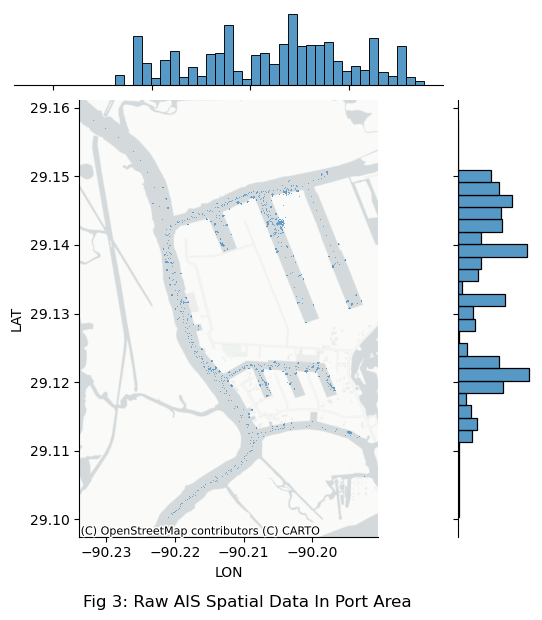

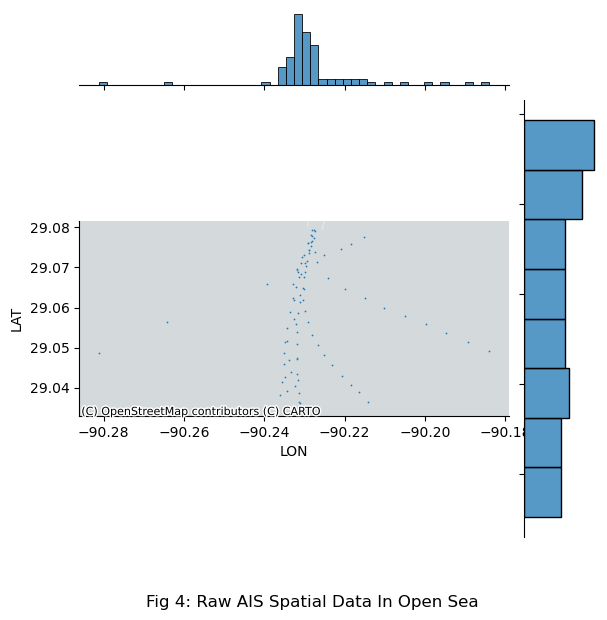

In [29]:
# Generate scatter plots of the truncated data

# set source for basemaps
map_source = ctx.providers.CartoDB.PositronNoLabels

# Port area
joint_axes = sns.jointplot(
    data = port_ais, x="LON", y="LAT", s=0.5)
plt.suptitle("Fig 3: Raw AIS Spatial Data In Port Area",  y=0)

ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=map_source)

# River mouth and sea
joint_axes = sns.jointplot(
    data = sea_ais, x="LON", y="LAT", s=2) # increase point size to make visible
plt.suptitle("Fig 4: Raw AIS Spatial Data In Open Sea",  y=0)

ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=map_source)

The Port area (Fig. 3) is densly clustered (as one would expect) with vessel constrained in waterways and berths.

In contrast, in the open sea (Fig. 4) data trajectories can be identified as dotted lines. We generate explicit trajectories using the moving pandas package as below. The majority of work in the anomaly detection literature laid out in Wolsing (2022) works with computed trajectories. We will now generte some below:

TrajectoryCollection with 9 trajectories


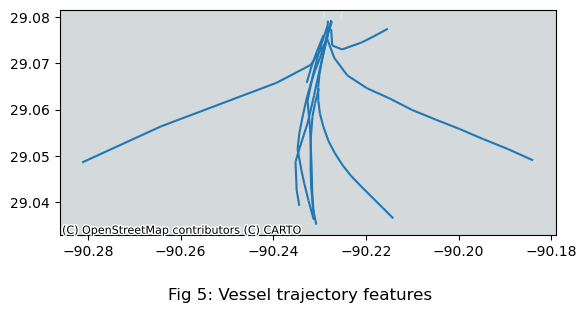

In [30]:
data = sea_ais
# Create trajectories
data['time'] = pd.to_datetime(data['BaseDateTime'], format='%Y-%m-%dT%H:%M:%S')
data = data.set_index('time')

# convert pandas dataframe in geod data frame
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(x=data.LON, y=data.LAT))

# Specify minimum length for a trajectory (in degrees)
minimum_length = 0.01

# use moving pandas package to generate collection of vessel specific trajectories
collection = mpd.TrajectoryCollection(gdf, 'MMSI', min_length=minimum_length)

# Get number of trajectories
print(collection)

# plot
ctx.add_basemap(
    collection.plot(),
    crs="EPSG:4326",
    source=map_source)
plt.suptitle("Fig 5: Vessel trajectory features",  y=0.15);


We can think of trajectories in Fig. 5 as spatiotemporal features that could be statistically modelled - indeed there are a many papers that do this such as Zhen et al., (2017) and Li et al., (2018), in both cases trajectories are clustered as part of anomaly detection processes.

A common approach to modelling random spatial data intensity is kernel density estimation. We can use the seaborn package to generate Gaussian kernels on the data as shown below:

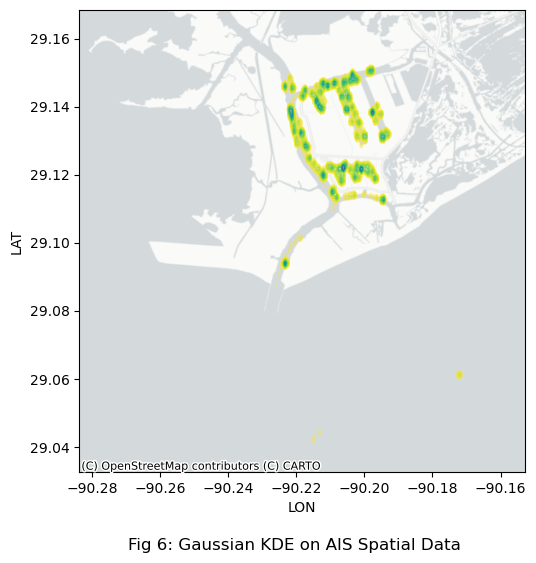

In [10]:
# KDE
# https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Generate and add KDE with a shading of 50 gradients
sns.kdeplot(
    x="LON",
    y="LAT",
    data=ais_data,
    n_levels=50,
    bw_method = None, # 'scott’, ‘silverman’, or scalar. None="scott"
    bw_adjust=0.25, # manual smoothing parameter - otherwise determined by bw_methof
    fill=True,
    alpha=0.3,
    cmap="viridis_r")

plt.suptitle("Fig 6: Gaussian KDE on AIS Spatial Data",  y=0)

# Add basemap
ctx.add_basemap(ax,
                crs="EPSG:4326",
                source=map_source)



The above plot is dominated by the dense areas in the port. Let's look only at the open sea:

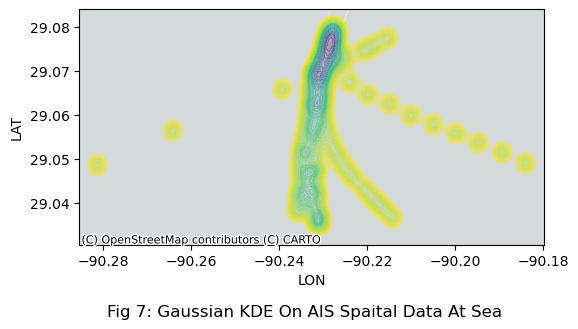

In [11]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Generate and add KDE with a shading of 50 gradients

sns.kdeplot(
    x="LON",
    y="LAT",
    data=sea_ais,
    n_levels=50,
    bw_method = None, # 'scott’, ‘silverman’, or scalar. None="scott"
    bw_adjust=0.25, # manual smoothing parameter - otherwise determined by bw_methof
    fill=True,
    alpha=0.3,
    cmap="viridis_r")

plt.suptitle("Fig 7: Gaussian KDE On AIS Spaital Data At Sea",  y=0.2)

# Add basemap
ctx.add_basemap(ax,crs="EPSG:4326",
                source=map_source)


Fig. 7 shows a nice representation of 'normal' positions at sea with a clear shipping route down the middle of the area. Given the inherent complexity of the data (clearly highly inhomogeneous and anisotropic) KDEs may provide a useful method of modelling local behaviour.

We can compare this a standard clustering method - DBSCAN:

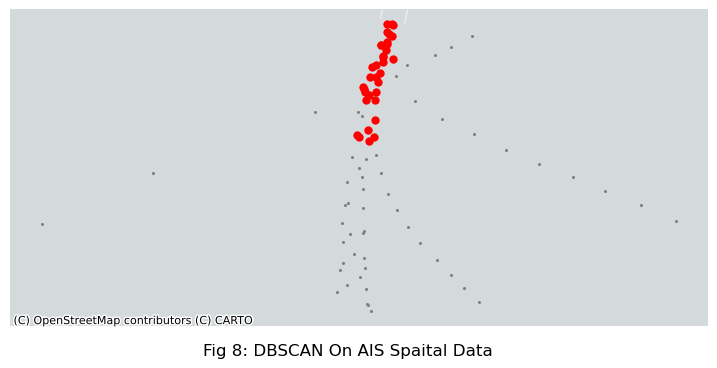

In [12]:
# Apply DBSCAN to data

#df = ais_data
df = sea_ais

# Code modified from 'Geographic Data Science with Python'
clusterer = DBSCAN(eps=0.002)

# Fit to our data
clusterer.fit(df[["LON", "LAT"]])
lbls = pd.Series(clusterer.labels_, index=df.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Subset points that are not part of any cluster (noise)
noise = df.loc[lbls == -1, ["LON", "LAT"]]

# Plot noise in grey
ax.scatter(noise["LON"], noise["LAT"], c="grey", s=5, linewidth=0)

# Plot all points that are not noise in red
ax.scatter(
    df.loc[df.index.difference(noise.index), "LON"],
    df.loc[df.index.difference(noise.index), "LAT"],
    c="red",
    linewidth=0)

# Add basemap
ctx.add_basemap(ax,
                crs="EPSG:4326",
                source=ctx.providers.CartoDB.PositronNoLabels)

plt.suptitle("Fig 8: DBSCAN On AIS Spaital Data",  y=0.3)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

Fig. 8 clearly illustrates the problem with clustering to raw spatial data: vessels spend a lot of time on their own, so simple clustering is not suitable for this problem. Where is it used, it is applied to trajectories (Li et al., 2018). This appears to be useful in enclosed waterways where trajectories are parallel (Li et al., 2018 uses the Mississippi river), but as we have seen, we see perfectly normal spatially divergent trajectories (vessels exiting a river mouth into the open sea) for which even this method would not work.

DBSCAN is probably more useful for automatically identifying stationary points such as ports, waypoints and anchorages. Normal vessel movements are classified as anomalies - which is not very useful in our analysis. Above we can see clustering at the river mouth, which is a waypoint.

We could try a number of unsupervised clustering approaches including K-means clustering and Gaussian Mixed Models. As with DBSCAN, the result would be trivially obvious clusters in 2D space without with low discriminatory power.

Isolation forests (an anomaly detection method that finds most unusual observations by the ease with which they can separated from the rest of the data) present a similar problem. When applied to spatial data, they simply locate edge points which is not informative in the context of anomaly detection in locally constrained samples.

KDEs seem to be more effective as the impose more bias, but they will have similar issues to clustering models.


Another approach from spatital statistics is the quadrat count. Below is an illustrative example:

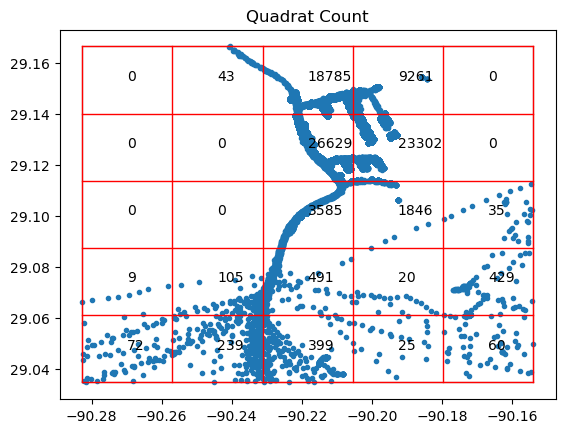

Fig 9: Illustrative Quadrat Count On AIS Transmissions


In [13]:
coordinates = ais_data[["LON", "LAT"]].values
qstat = QStatistic(coordinates, nx = 5, ny = 5)
qstat.plot()
print("Fig 9: Illustrative Quadrat Count On AIS Transmissions")


Fig. 9 shows that cell based counts can be a useful representation. This approach is somewhat unfashionable in the anomaly detection literature and is typically used for building many local models (e.g. Ristic 2014) or regression models (e.g. Ford et al. 2018). At higher resolution, it may be useful representation for deep learning problems. The functions below are designed for this purpose:

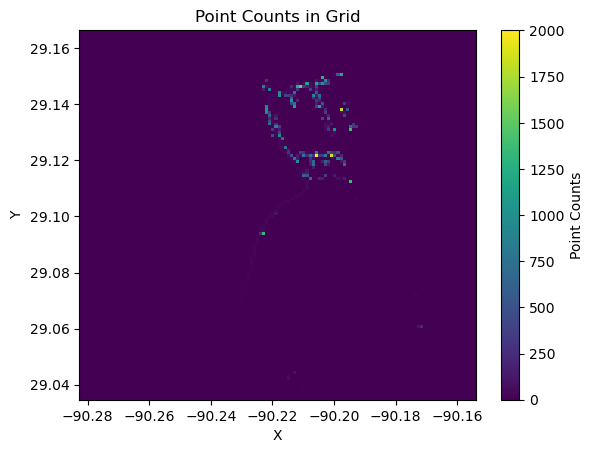

Fig 10: Point Counts On 128x128 Grid On All AIS Data


In [14]:
def count_points_in_grid(df, num_cells_x, num_cells_y, xmin, xmax, ymin, ymax):
    # Create the grid
    x_grid = np.linspace(xmin, xmax, num_cells_x + 1)
    y_grid = np.linspace(ymin, ymax, num_cells_y + 1)

    # Count points in each cell
    counts, _, _ = np.histogram2d(df['LON'], df['LAT'], bins=[x_grid, y_grid])

    # Create a DataFrame with the cell counts
    grid_df = pd.DataFrame(counts.T, columns=range(num_cells_x), index=range(num_cells_y))
    
    return grid_df

def plot_grid(grid_df, xmin, xmax, ymin, ymax):
    # Create a meshgrid for the cell coordinates
    x_grid, y_grid = np.meshgrid(np.linspace(xmin, xmax, grid_df.shape[1] + 1),
                                 np.linspace(ymin, ymax, grid_df.shape[0] + 1))

    # Plot the cell counts as a heatmap
    plt.pcolormesh(x_grid, y_grid, grid_df.values)
    plt.colorbar(label='Point Counts')  # Add colorbar with label

    # Set axis labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Point Counts in Grid')

    # Show the plot
    plt.show()


# Run grid count on data
df = ais_data
num_cells_x = 128  # Number of cells along the x-axis
num_cells_y = 128  # Number of cells along the y-axis
xmin, xmax = df['LON'].min(), df['LON'].max()  # Min and max values of x-coordinate
ymin, ymax = df['LAT'].min(), df['LAT'].max()  # Min and max values of y-coordinate

grid_df = count_points_in_grid(df, num_cells_x, num_cells_y, xmin, xmax, ymin, ymax)
plot_grid(grid_df, xmin, xmax, ymin, ymax)
print("Fig 10: Point Counts On 128x128 Grid On All AIS Data")

As usual, any density based approach is dominated by the port (Fig. 10). Let's look at open sea only:

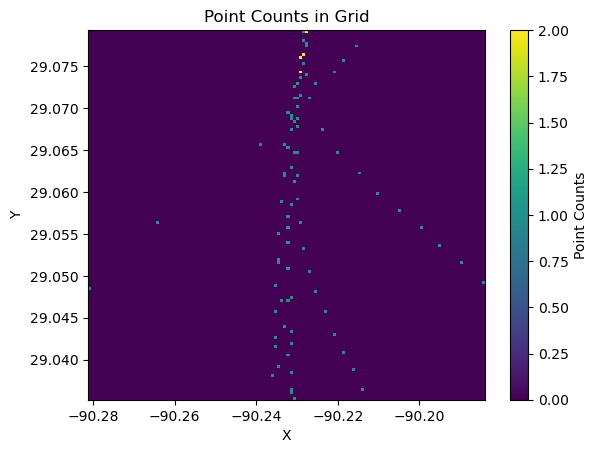

Fig 11: Point Counts On 128x128 Grid On AIS Data At Sea


In [15]:
# Runf grid count on data
df = sea_ais
num_cells_x = 128  # Number of cells along the x-axis
num_cells_y = 128  # Number of cells along the y-axis
xmin, xmax = df['LON'].min(), df['LON'].max()  # Min and max values of x-coordinate
ymin, ymax = df['LAT'].min(), df['LAT'].max()  # Min and max values of y-coordinate

grid_df = count_points_in_grid(df, num_cells_x, num_cells_y, xmin, xmax, ymin, ymax)
plot_grid(grid_df, xmin, xmax, ymin, ymax)
print("Fig 11: Point Counts On 128x128 Grid On AIS Data At Sea")

Figure 11 appears to be a compact representation of the AIS data suitable for deep learning. Let's generate more samples by stratifying the data through time:

In [16]:
def generate_time_pairs(start_time_str, increment_mins, period_hours):
    '''Function to generate contiguous start and end times'''
    # Convert start time string to datetime object
    start_time = dt.datetime.strptime(start_time_str, "%Y-%m-%dT%H:%M:%S")

    # Calculate end time as start time + 24 hours
    end_time = start_time + timedelta(hours=period_hours)

    # Generate pairs of start and end times spanning 5-minute intervals
    time_pairs = []
    current_time = start_time
    while current_time < end_time:
        next_time = current_time + timedelta(minutes=increment_mins)
        #time_pairs.append((current_time, next_time))
        time_pairs.append((current_time.strftime("%Y-%m-%dT%H:%M:%S"), next_time.strftime("%Y-%m-%dT%H:%M:%S")))
        current_time = next_time

    return time_pairs


# Generate start / end strings for hour windows in 24 hour data sample
start_time_str = "2020-03-30T00:00:00"
period_hours = 23
increment_mins = 60
time_pairs = generate_time_pairs(start_time_str, increment_mins, period_hours)


Now slice the data into hour long windows with spatial boundaries on the open sea. We will lower the resolution to keep our representation as simple as possible.

(23, 32, 32)


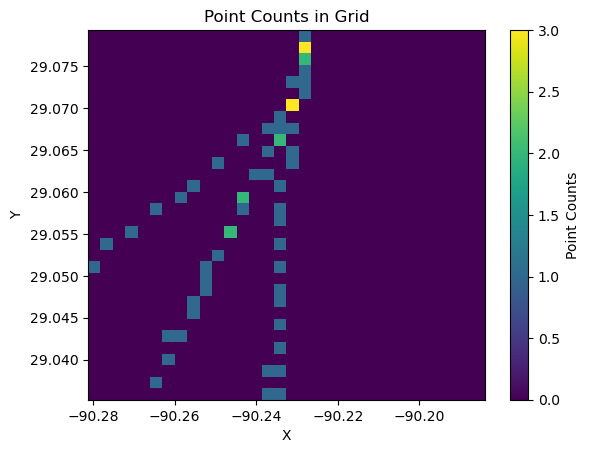

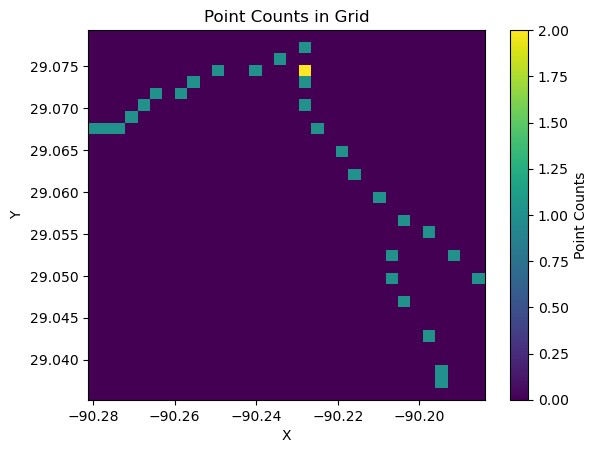

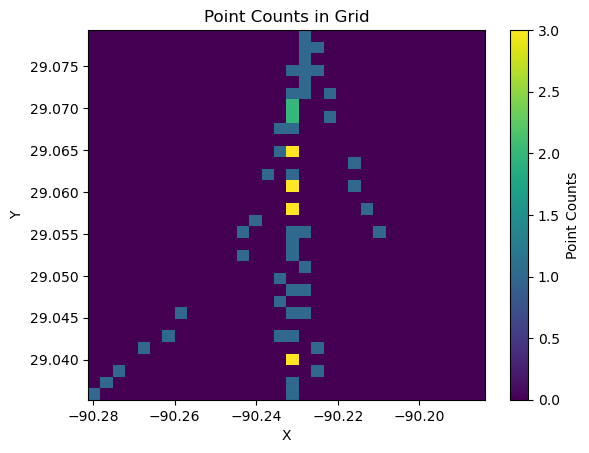

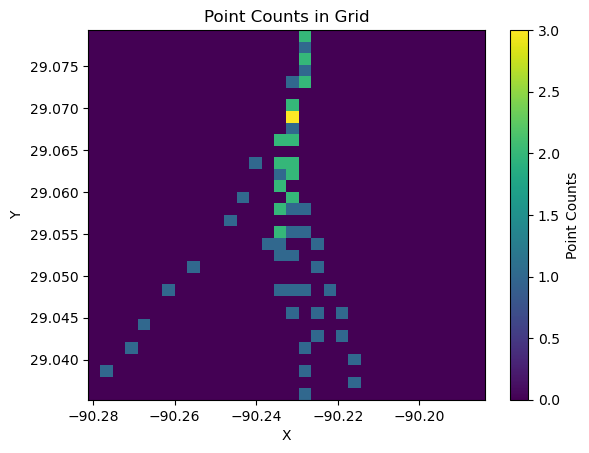

Fig 12: Example point Counts On 128x128 Grid On AIS Data At Sea In Different 1H Windows


In [17]:
# Create array of time windowed grid counts (snapshots).

df = ais_data # we will create snapshots with original data source

# reduce resolution
num_cells_x = 32  # Number of cells along the x-axis
num_cells_y = 32  # Number of cells along the y-axis

# set fixed grid size for all snapshots based on previously space-bound 'sea_ais' dataframe
xmin, xmax = sea_ais['LON'].min(), sea_ais['LON'].max()  # Min and max values of x-coordinate
ymin, ymax = sea_ais['LAT'].min(), sea_ais['LAT'].max()  # Min and max values of y-coordinate

# Restrict snapshots to same coordinates as 'sea_ais' (river mouth & sea)
lat_top = 29.08
lat_bottom = 29.02
lon_west = -90.30
lon_east = -90.18

# create empty numpy array to store indexed grids
num_grids = len(time_pairs)  # Number of snapshots
AIS_snapshots = np.zeros((num_grids, num_cells_x, num_cells_y))

# Print the shape of the 3D array
print(AIS_snapshots.shape)

# Step through time bounds and create snapshots
for i in range(0,len(time_pairs)):
    # get start and end times
    time_start  = dt.datetime.fromisoformat(time_pairs[i][0])
    time_end  = dt.datetime.fromisoformat(time_pairs[i][1])
    
    # create snapshot from original data 
    snapshot = ais_fitler(df, type_codes, time_start, time_end, 
                    lat_top, lat_bottom, lon_west, lon_east)
    
    # perform grid counts on snapshot and store representation in numpy array 
    AIS_snapshots[i] = count_points_in_grid(snapshot, 
                                            num_cells_x, num_cells_y, 
                                            xmin, xmax, 
                                            ymin, ymax).to_numpy()
    
# look at first 4 time frames
for i in range(0,4):
    plot_grid(pd.DataFrame(AIS_snapshots[i]), xmin, xmax, ymin, ymax)

print("Fig 12: Example point Counts On 128x128 Grid On AIS Data At Sea In Different 1H Windows")
  


The above figures are reminiscent of simple images used to train neural networks (such as MNIST data). For anomaly detection a variational autoencoder may be an effective method for this problem:

The model learns to reconstruct the input data by encoding it into a low dimensional latent space and then decoding back to the input space. For an unsupervised problem such as this (we don't have labelled anomalies) a suitably structured and trained VAE will learn the majority normal patterns of vessel behaviour and ignore anomalies. This is because the VAE latent space acts to regularise the possible representations by assuming a specific prior distribution (often Gaussian).

Anomalies can be detected by passing them into the model and observing the reconstruction error. The model should generate plausible normal behaviour and not be able to reconstruct the anomaly. This will give a relatively high reconstruction error. We can select a threshold reconstruction error above which we classify an observation as anomalous.

This allows a mathematically compact and principled way to find detect anomalies without requiring hand crafted rules or theory based model bias as used extensively in the majority of the literature on this topic.

Let’s try a baselining (proof of concept) exercise with this data on a Variational Autoencoder (VAE). Note that we use a tiny dataset here and the VAE code is very suboptimal. The objective is to prove that future work on a VAE is worth the effort.

For this test implementation we will label some of the data normal and some anomalous. By inspection, the first 17 of 23 examples generate above look 'normal' enough (I only display 4 in this notebook for submission). We can consider this a toy dataset that will be reused many times in training. The last 6 examples are anomalies.

In [26]:
# Labels for 1 hour snapshots. ) 0 = normal, 1 = anomaly
# Labels are based on visual inspection of the snapshots generated above
labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
len(labels)

23

Note that most of the code used in the VAE section below was refactored from a Kaggle competition notebook "VAE to Detect Anomalies on Digits" available here https://www.kaggle.com/code/kmader/vae-to-detect-anomalies-on-digits .

This was done out of expediency given the relative complexity of this method and that the purpose of this notebook was investigate the feasibility of various methods on AIS data. The below code is not optimal and uses methods that have been superseded by TensorFlow 2.0. If a VAE is used in the final research, code will be developed in TF2.

In [19]:
# Get training data into right shapes and format for VAE

# flatten grids
AIS_snapshots_2d = AIS_snapshots.reshape(AIS_snapshots.shape[0], -1)
# create traing set
train = pd.DataFrame(AIS_snapshots_2d)
# Create a new column 'label' in the DataFrame with the list of labels
train.insert(0, 'label', labels)
# Get Y labels
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
# Normalize the data
X_train = X_train / AIS_snapshots.max()
# Reshape image in 3 dimensions (height = 32px, width = 32px , chanel = 1)
X_train = X_train.values.reshape(-1,32,32,1)

# create an anomaly hold out group and then only train with the remaining snapshots
anom_mask = (Y_train==1)
anomaly_test = X_train[anom_mask]
X_train = X_train[~anom_mask]
Y_train = Y_train[~anom_mask]

# make a test set the same size as the anomaly set
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=anomaly_test.shape[0], random_state=42)
print('Training Images', X_train.shape, 'Testing Images', X_test.shape, 'Anomaly Images', anomaly_test.shape)

Training Images (11, 32, 32, 1) Testing Images (6, 32, 32, 1) Anomaly Images (6, 32, 32, 1)


In [20]:
# Paramters for VAE - this is not optimised!
batch_size = 256
original_shape = X_train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epochs = 50
epsilon_std = 1.0

In [21]:
# Encoder layers
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

# Latent space
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Latent space sampler
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder layers
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

# Decoder model
f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_snapshot = Reshape(original_shape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_snapshot)

# Compute VAE loss
cross_ent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(cross_ent_loss + kl_loss)

# Construct model
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Metal device set to: Apple M1 Pro
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 1024)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          131200      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                            

2023-06-18 19:56:33.023189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-18 19:56:33.023290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
# Train model
vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(anomaly_test, None))

Epoch 1/50


2023-06-18 19:56:33.252573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-18 19:56:33.694930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 710.4142 - val_loss: 691.3934
Epoch 2/50
1/1 [==============================] - 0s 31ms/step - loss: 696.2695 - val_loss: 678.0316
Epoch 3/50
1/1 [==============================] - 0s 31ms/step - loss: 680.7874 - val_loss: 657.3018
Epoch 4/50
1/1 [==============================] - 0s 29ms/step - loss: 662.0240 - val_loss: 632.3845
Epoch 5/50


2023-06-18 19:56:34.194130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 32ms/step - loss: 638.5142 - val_loss: 602.7384
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 609.5225 - val_loss: 568.8673
Epoch 7/50
1/1 [==============================] - 0s 27ms/step - loss: 575.5935 - val_loss: 530.8372
Epoch 8/50
1/1 [==============================] - 0s 28ms/step - loss: 538.5509 - val_loss: 490.0593
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 496.3792 - val_loss: 446.9026
Epoch 10/50
1/1 [==============================] - 0s 27ms/step - loss: 449.6310 - val_loss: 402.3823
Epoch 11/50
1/1 [==============================] - 0s 28ms/step - loss: 404.2603 - val_loss: 357.7634
Epoch 12/50
1/1 [==============================] - 0s 28ms/step - loss: 352.9857 - val_loss: 315.3998
Epoch 13/50
1/1 [==============================] - 0s 29ms/step - loss: 309.0216 - val_loss: 276.3702
Epoch 14/50
1/1 [==============================] - 0s 29ms/step - loss: 268.9238 - val_loss: 241.2

1/1 [==============================] - 0s 11ms/step


2023-06-18 19:56:35.789041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Fig 13: Reconstrcution Errors On Toy Dataset


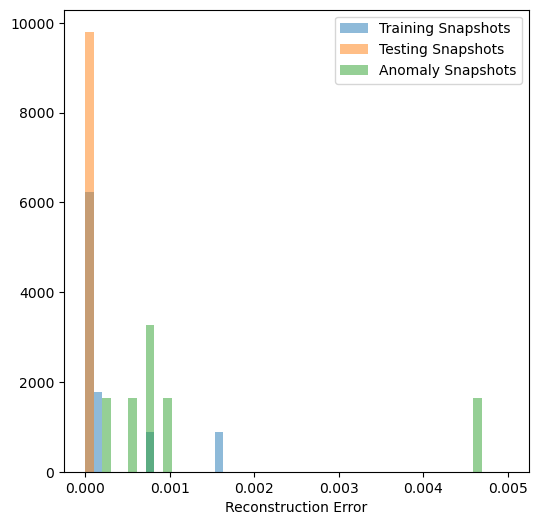

In [23]:
# Plot the reconstruction loss on normal vs anomalous data
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.hist(model_mse(X_train), bins = np.linspace(0, .005, 50), 
         label = 'Training Snapshots', density = True, alpha = 0.50)
ax1.hist(model_mse(X_test), bins = np.linspace(0, .005, 50), 
         label = 'Testing Snapshots', density = True, alpha = 0.50)
ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .005, 50), 
         label = 'Anomaly Snapshots', density = True, alpha = 0.50)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');
print("") # formatting gap
print("Fig 13: Reconstrcution Errors On Toy Dataset")

In Fig. 13 we see the reconstruction errors are highest on the anomalies. We can't really draw any conclusions because the dataset is so small, but this is the sort of thing we'd hope to see on a larger training set. An anomaly detection threshold would be set somewhere on the x axis. 

Let's use a ROC curve to see how well the detector does on our toy problem:


1/1 [==============================] - 0s 10ms/step

Fig 14: ROC Curve on Toy Dataset


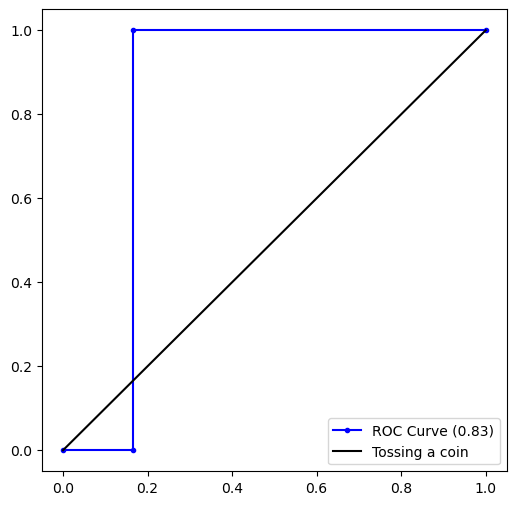

In [24]:
# Get MSEs for snapshots
mse_score = np.concatenate([model_mse(X_test), model_mse(anomaly_test)],0)
true_label = [0]*X_test.shape[0]+[1]*anomaly_test.shape[0]

# Generate ROC curve and calc score
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)

# Plot
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Tossing a coin')
ax1.legend();
print("")  # gap
print("Fig 14: ROC Curve on Toy Dataset")

Finally let's display AIS snapshots and reconstructions to see what is going on in the model:

1/1 [==============================] - 0s 10ms/step

Fig 15: Real and Reconstructed Snapshots


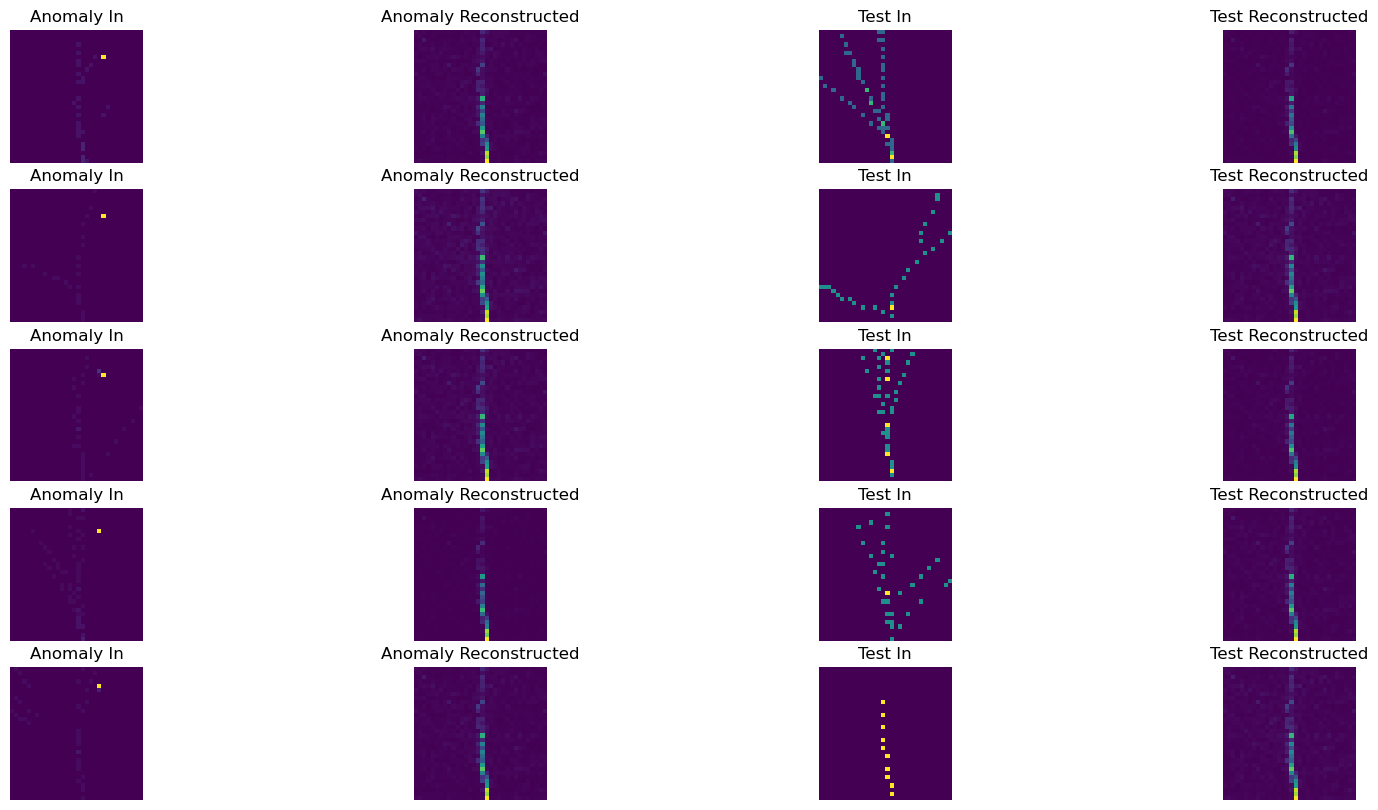

In [25]:
# set up subplots
fig, m_axs = plt.subplots(5,4, figsize=(20, 10))
[c_ax.axis('off') for c_ax in m_axs.ravel()]

# get original snapshots and predictions
for i, (axa_in, axa_vae, axt_in, axt_vae) in enumerate(m_axs):
    axa_in.imshow(anomaly_test[i,:,:,0])
    axa_in.set_title('Anomaly In')
    axa_vae.imshow(vae.predict(anomaly_test[i:i+1])[0,:,:,0])
    axa_vae.set_title('Anomaly Reconstructed')
    axt_in.imshow(X_test[i,:,:,0])
    axt_in.set_title('Test In')
    axt_vae.imshow(vae.predict(X_test[i:i+1])[0,:,:,0])
    axt_vae.set_title('Test Reconstructed')
    
print("")
print("Fig 15: Real and Reconstructed Snapshots")

The results show that the VAE has learnt a simple (probably single) representation of a normal snapshot, getting the basic symmetry and structure correct. Whilst the results look promising, the anomaly examples are probably trivially easy (but are real examples - this is a single stationary vessel at night). 


We can reasonably conclude that the idea of using a VAE for anomaly detection on this data is reasonable, but a significant amount of further work is required to develop a useful model.


#### Conclusion

This notebook has performed some basic explanatory data analysis and experimented with a number of methods to 1) represent the AIS data and 2) to model it.

Density based methods such as clustering and KDEs are common approaches in machine learning applied to anomaly detection, but in this problem domain their application requires a significant degree of feature engineering so that it can be applied on vessel trajectories rather than directly to the spatial data.

In this notebook, representations of AIS data were developed that are similar to image data commonly used with Variational Autoencoders. A cell based counting method (quadrat method) was applied, thus retaining the spatial properties of the raw AIS data whilst making it tractable as a deep learning problem. These representations allowed modelling of 'normal' AIS data with a basic and relatively straighforward VAE implementation that has been applied to popular datasets like MNIST. The results are encouraging suggesting that this method could be developed into a practical anomaly detection method capable of modelling the complex behaviour of seaborn vessels.

Significant further work is required to increase the quanrtity of training data and develop a VAE architecture specifically for this problem. Given the preponderance of vessel trajectories in the AIS anomaly detection literature, training a VAE on vessel trajectories may yield improved results, so this will be tested as well.

Finally, a very focussed literature review on the use of VAEs on AIS data need to be conducted. Whilst most papers have been found via Wolsing et al., (2022) and extensive search of the Imperial College online library, exhaustive reference searches have not been conducted yet.

#### References

Ford JH, Peel D, Kroodsma D, Hardesty BD, Rosebrock U, Wilcox C (2018) Detecting suspicious activities at sea based on anomalies in Automatic Identification Systems transmissions. PLoS ONE 13(8): e0201640. https://doi.org/10.1371/journal.pone.0201640

Li, Huanhuan & Liu, Jingxian & Wu, Kefeng & Yang, Zaili & Liu, Wen & Xiong, Naixue. (2018). Spatio-Temporal Vessel Trajectory Clustering Based on Data Mapping and Density. IEEE Access. PP. 10.1109/ACCESS.2018.2866364.

Sergio J. Rey, Dani Arribas-Bel, Levi J. Wolf, Geographic Data Sicence (2020). https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html 

Svanberg, M., Santén, V., Hörteborn, A., Holm, H. & Finnsgård, C. (2019) AIS in maritime research. Marine Policy. 106 103520. 10.1016/j.marpol.2019.103520.

Wolsing, K.; Roepert, L.; Bauer, J.; Wehrle, K. Anomaly Detection in Maritime AIS Tracks: A Review of Recent Approaches. J. Mar. Sci. Eng. 2022, 10, 112. https://doi.org/10.3390/jmse10010112

Zhen, R., Jin, Y., Hu, Q., Shao, Z., & Nikitakos, N. (2017). Maritime Anomaly Detection within Coastal Waters Based on Vessel Trajectory Clustering and Naïve Bayes Classifier. The Journal of Navigation, 70(3), 648-670. doi:10.1017/S0373463316000850

